## Dynamic Bayesian Networks

This notebook is made of the following main steps:

* Run the R script in ../Modules/6-1_DBN_CDSSpread_ContDefArt_Energy.R to estimate dynamic bayesian networks for the specified sector

* Estimate conditional probabilities and make inference on the resulting networks in the 3 time windows in order to compute link strength

* Estimate partial correlations between linked issuers via tigramite

* Plot the resulting graphs

The R script saves some files in the path gho-asc-gawm-22-riskasc-criskcontagion/Output/6.1_DBN_Results/dbn_fit_files:

* *sector*_static_0.csv: adjacency matrix of the dag obtained by fitting the static BN on the first period 
* *sector*_dyn_first_0.csv: adjacency matrix of the dag obtained by fitting the dynamic BN on periods 0-1 expressing links among the nodes in period 0
* *sector*_dyn_cross_0_1.csv: adjacency matrix of the dag obtained by fitting the dynamic BN on periods 0-1 expressing links from nodes in period 0 to nodes in period 1
* *sector*_dyn_last_1.csv: adjacency matrix of the dag obtained by fitting the dynamic BN on periods 0-1 expressing links among the nodes in period 1
* *sector*_dyn_first_1.csv: adjacency matrix of the dag obtained by fitting the dynamic BN on periods 1-m1 expressing links among the nodes in period 1
* *sector*_dyn_cross_1_2.csv: adjacency matrix of the dag obtained by fitting the dynamic BN on periods 1-m1 expressing links from nodes in period 1 to nodes in period m1
* *sector*_dyn_last_2.csv: adjacency matrix of the dag obtained by fitting the dynamic BN on periods 1-m1 expressing links among nodes in period m1

In [1]:
import subprocess
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import networkx as nx
from matplotlib import pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from pgmpy.inference import VariableElimination
import sys
sys.path.append('../Modules')
from tigramite_utils import *
from utils_bayesian_networks import *

/anaconda/envs/work_env/lib/python3.9/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/anaconda/envs/work_env/lib/python3.9/site-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/anaconda/envs/work_env/lib/python3.9/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'gpytorch'
  warnings.warn(str(e))


In [2]:
# Specify sector and number of bootstrapped datasets to be used in fit of dynamic bayesian networks

# Possible improvements:
# - Pass parameters specifying extreme dates of periods or number of periods

sector = 'Energy'
num_boot = 1000

cmd = 'Rscript --vanilla ../Modules/6-1_DBN_CDSSpread_ContDefArt_Energy.R ' +\
       sector + ' ' + str(num_boot)

In [11]:
# Define discrete status for the specified sector in the 3 periods and on the whole time horizon
define_discrete_states_based_on_volatility_jumps(sector, 5, ['2019-01-01', '2020-10-01'],
                                                 '../Data/discrete_status_bn/')

Maximum Timestamp of available data point 2015-05-21 00:00:00
Minimum Timestamp of not null data point cross time series 2021-12-06 00:00:00


In [3]:
# Launch R script to fit dynamic bayesian networks
# .csv files containing adjacency matrix of the discovered DAGs are saved in the path
# ../Output/6.1_DBN_Results/dbn_fit_files/

res = subprocess.call(cmd, shell=True)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union

Loading required package: graph
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:bnlearn’:

    score

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted,

[1] "Sector is Energy"
[1] "Fitting static BN for period 0"


bnstruct :: Generating bootstrap samples ...
bnstruct :: Bootstrap samples generated.
bnstruct :: learning the structure using MMHC ...
bnstruct :: learning using MMHC completed.
bnstruct :: learning network parameters ... 
bnstruct :: parameter learning done.


[1] "Fitting dynamic BN between periods 0 and 1"


bnstruct :: Generating bootstrap samples with imputation ...
bnstruct :: Bootstrap samples generated.
bnstruct :: learning network parameters ... 
bnstruct :: parameter learning done.
bnstruct :: learning the structure using MMHC ...
bnstruct :: learning using MMHC completed.
bnstruct :: learning network parameters ... 
bnstruct :: parameter learning done.


[1] "Fitting dynamic BN between periods 1 and m1"


bnstruct :: Generating bootstrap samples with imputation ...
bnstruct :: Bootstrap samples generated.
bnstruct :: learning network parameters ... 
bnstruct :: parameter learning done.
bnstruct :: learning the structure using MMHC ...
bnstruct :: learning using MMHC completed.
bnstruct :: learning network parameters ... 
bnstruct :: parameter learning done.


In [4]:
# Read input data and results of dynamic bayesian network fitting performed in R

input_data = {}
input_data['0'] = pd.read_csv('../Data/discrete_status_bn/discrete_data_' + sector + '_status_0.csv', sep=',')
input_data['1'] = pd.read_csv('../Data/discrete_status_bn/discrete_data_' + sector + '_status_1.csv', sep=',')
input_data['m1'] = pd.read_csv('../Data/discrete_status_bn/discrete_data_' + sector + '_status_m1.csv', sep=',')

for i in input_data['0']:
    input_data['0'][i] = input_data['0'][i].astype('category')
    input_data['1'][i] = input_data['1'][i].astype('category')
    input_data['m1'][i] = input_data['m1'][i].astype('category')
    
net = {}
net['0'] = pd.read_csv('../Output/6.1_DBN_Results/dbn_fit_files/' + sector + '_static_0_BKP_1000.csv', sep=';')
net['1'] = pd.read_csv('../Output/6.1_DBN_Results/dbn_fit_files/' + sector + '_dyn_last_1_BKP_1000.csv', sep=';')
net['m1'] = pd.read_csv('../Output/6.1_DBN_Results/dbn_fit_files/' + sector + '_dyn_last_2_BKP_1000.csv', sep=';')
var_names = net['0'].columns

In [5]:
# Dictionaries to collect the graphs objects and the link strengths for the three periods
model_graphs = {}
link_strengths = {}

for status in ['0', '1', 'm1']:
    
    model_graph = nx.Graph()
    model_graph.add_nodes_from(var_names)
    model_graph = model_graph.to_directed()
    model_graph.add_edges_from([(var_names[np.where(net[status]==1)[0][i]], var_names[np.where(net[status]==1)[1][i]]) \
      for i in range(len(np.where(net[status]==1)[0]))])

    bn_model = BayesianNetwork(model_graph)
    bn_model.fit(input_data[status], estimator=MaximumLikelihoodEstimator)

    model_infer = VariableElimination(bn_model)
    link_strength = {}
    for edge in bn_model.edges():
        q = model_infer.query(variables=[edge[1]], evidence={edge[0]: 1}, show_progress=False)
        link_strength[edge] = q.values[2]
        
    model_graphs[status] = model_graph
    link_strengths[status] = link_strength

In [6]:
# Read input data useful to run conditional independence tests to estimate partial correlations

df_all, df_all_lookup, _, _, _ =\
    import_data_clustering_issuer_rf(issuer_curves_file_name='../Data/Sprd_5Y_Gesav_import_Sector_values.csv',
                                    fx_rf_file_name='../Data/Observations - UniverseFX.csv',
                                    local_rf_file_name='../Data/Observations - UniverseLOCAL.csv')

df_complete = pd.read_csv('../Data/conditional_volatility_issuers.csv', sep=';')
df_complete['Date'] = pd.to_datetime(df_complete['Date'])
df_complete = df_complete.set_index('Date', drop=True)

# Select only curves from a specified sector
curves_sector = df_all[['CurveID', 'MS_Sector']].loc[lambda x: x['CurveID'].isin(df_complete.columns)].\
    drop_duplicates().\
    loc[lambda x: x['MS_Sector'] == sector]['CurveID'].unique()
print('Number of curves in sector ' + sector + ': ' + str(len(curves_sector)))

df_sector = df_complete.loc[:,curves_sector]
df_sector.index = pd.to_datetime(df_complete.index)

min_date = min(df_complete.index)
max_date = max(df_complete.index)
df_periods = pd.DataFrame([['0', min_date, pd.to_datetime('2019-01-01')],
                          ['1', pd.to_datetime('2019-01-02'), pd.to_datetime('2020-10-01')],
                          ['m1', pd.to_datetime('2020-10-02'), max_date]],
                        columns=['status', 'min_date', 'max_date'])
df_periods

Number of curves in sector Materials: 15


status   min_date   max_date
0      0 2015-05-22 2019-01-01
1      1 2019-01-02 2020-10-01
2     m1 2020-10-02 2021-12-06

In [7]:
# Estimate partial correlation via tigramite for the different periods

significant_arcs = {}
dict_edge_labels = {}
node_colors = {}

for status in ['0', '1', 'm1']:
    
    print('Running PCMCI algorithm for status ' + status)
    
    significant_arcs_curr = pd.DataFrame(list(model_graphs[status].edges()), columns=['from', 'to'])

    significant_arcs[status], dict_edge_labels[status], node_colors[status] = \
        compute_partial_correlation_tigramite(df_sector, df_periods, status, model_graph=model_graphs[status], max_lag=30)
    

Running PCMCI algorithm for status 0
Running PCMCI algorithm for status 1
Running PCMCI algorithm for status m1


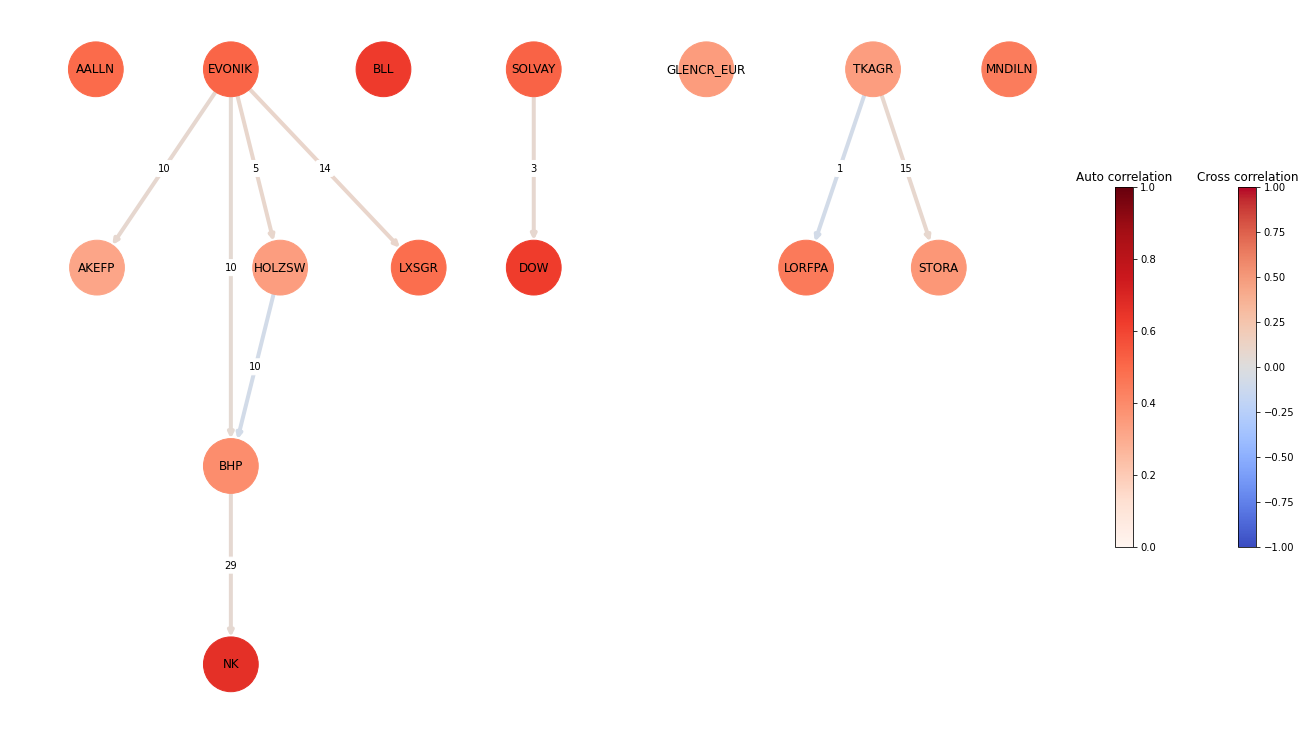

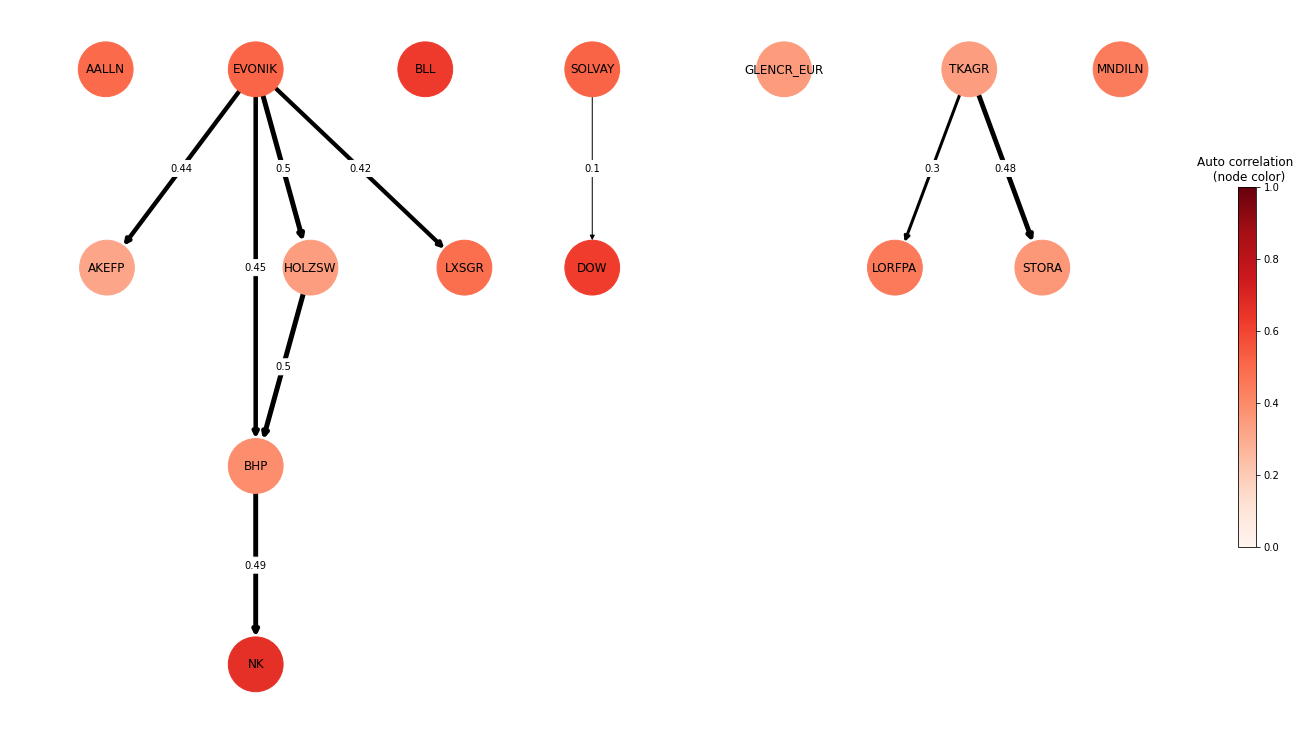

True


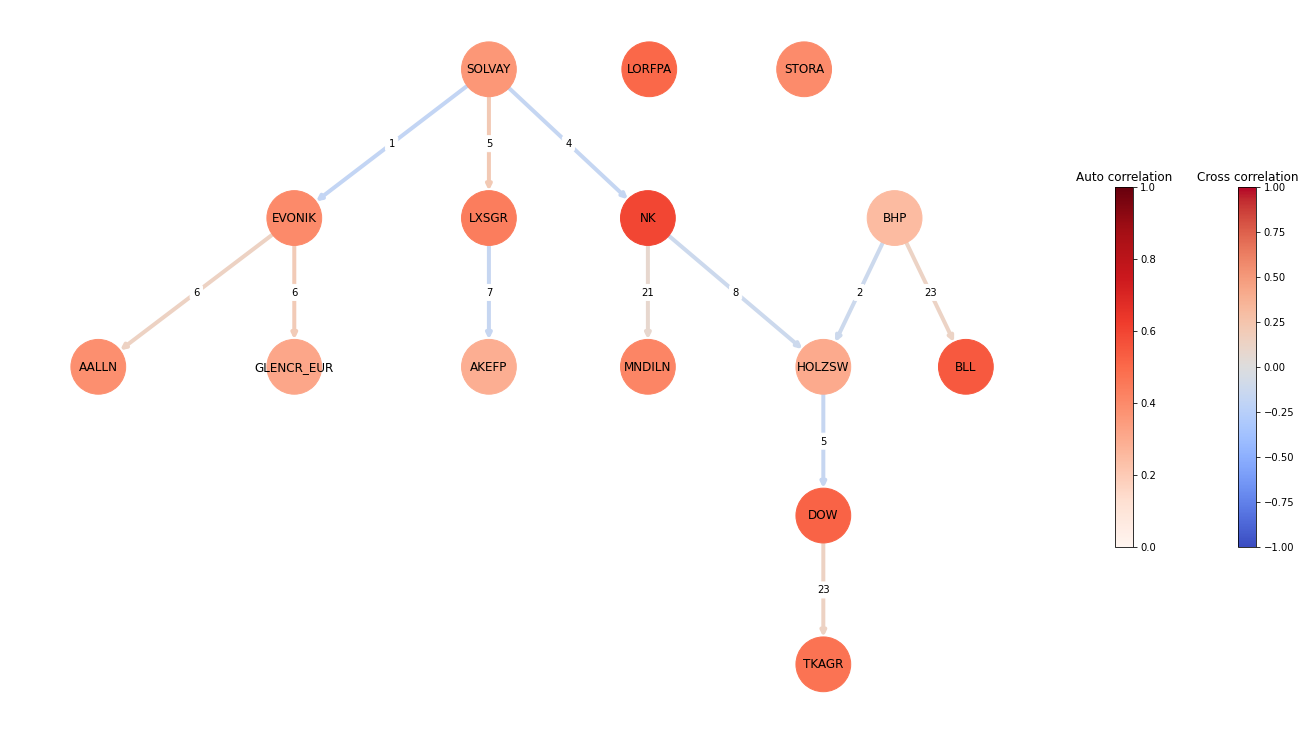

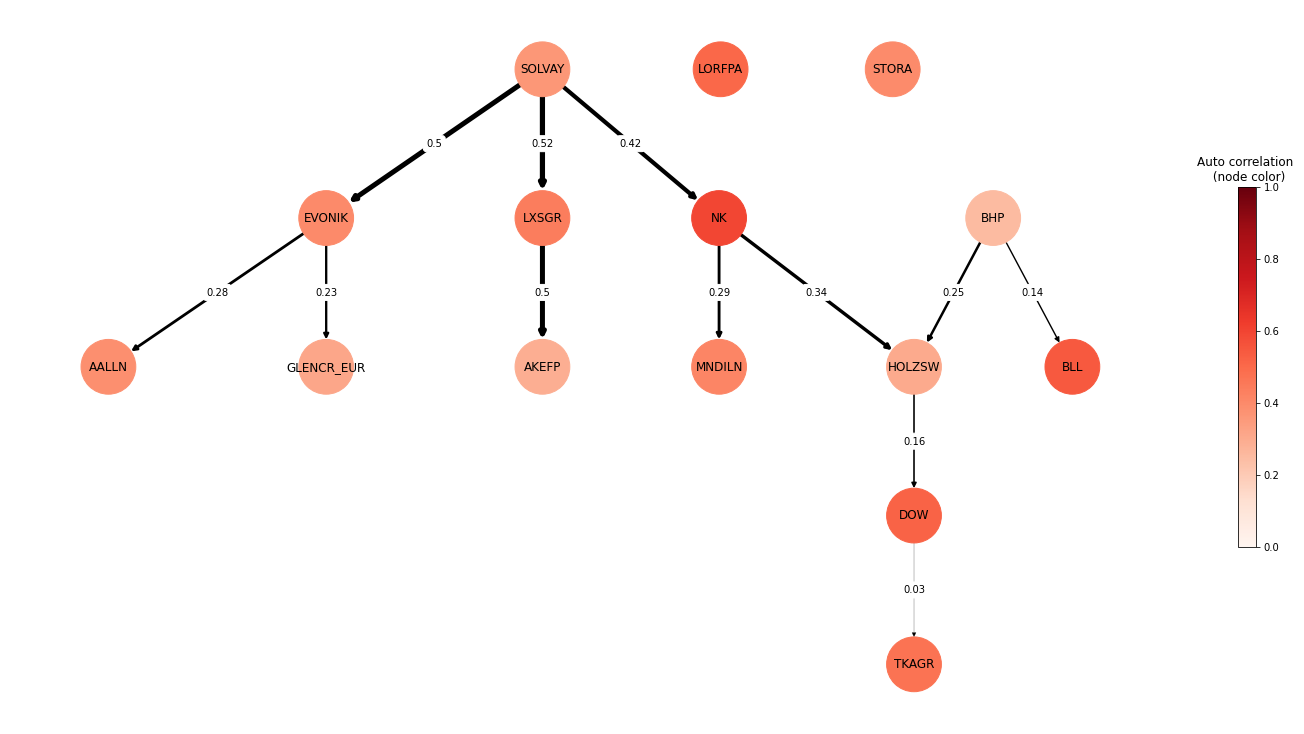

True


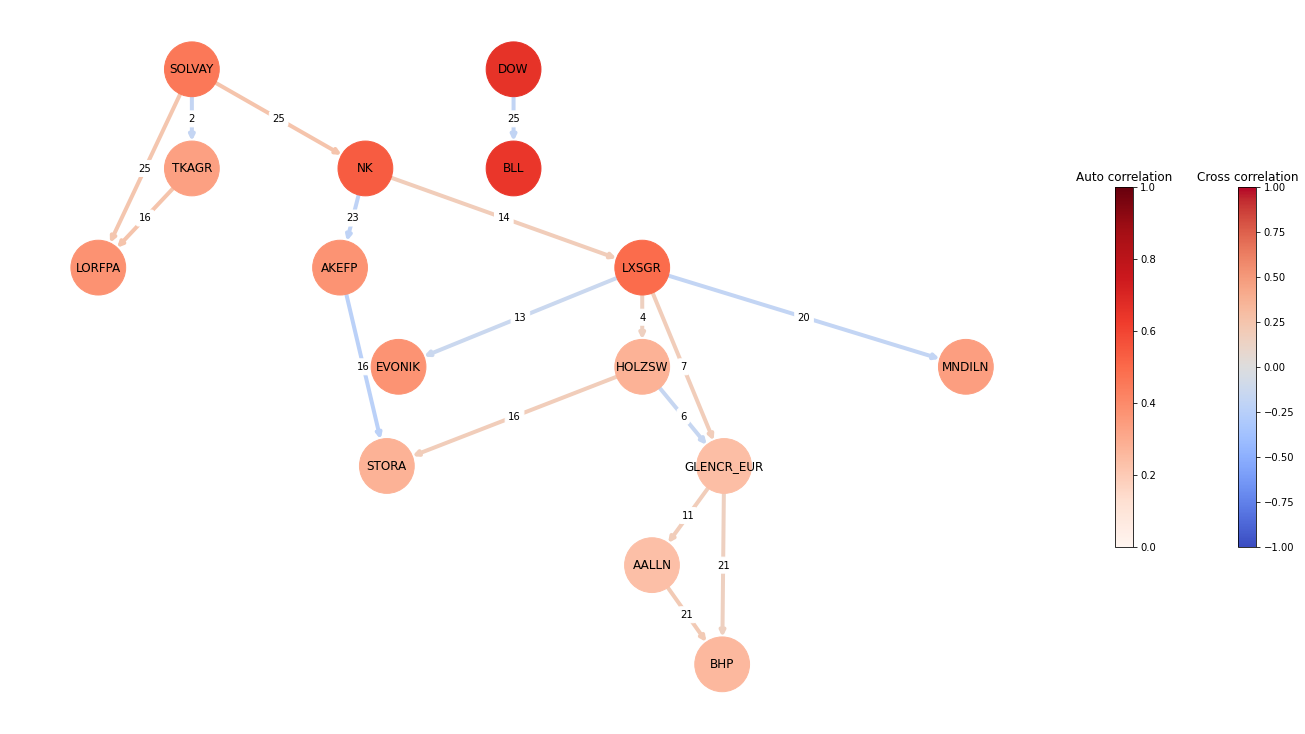

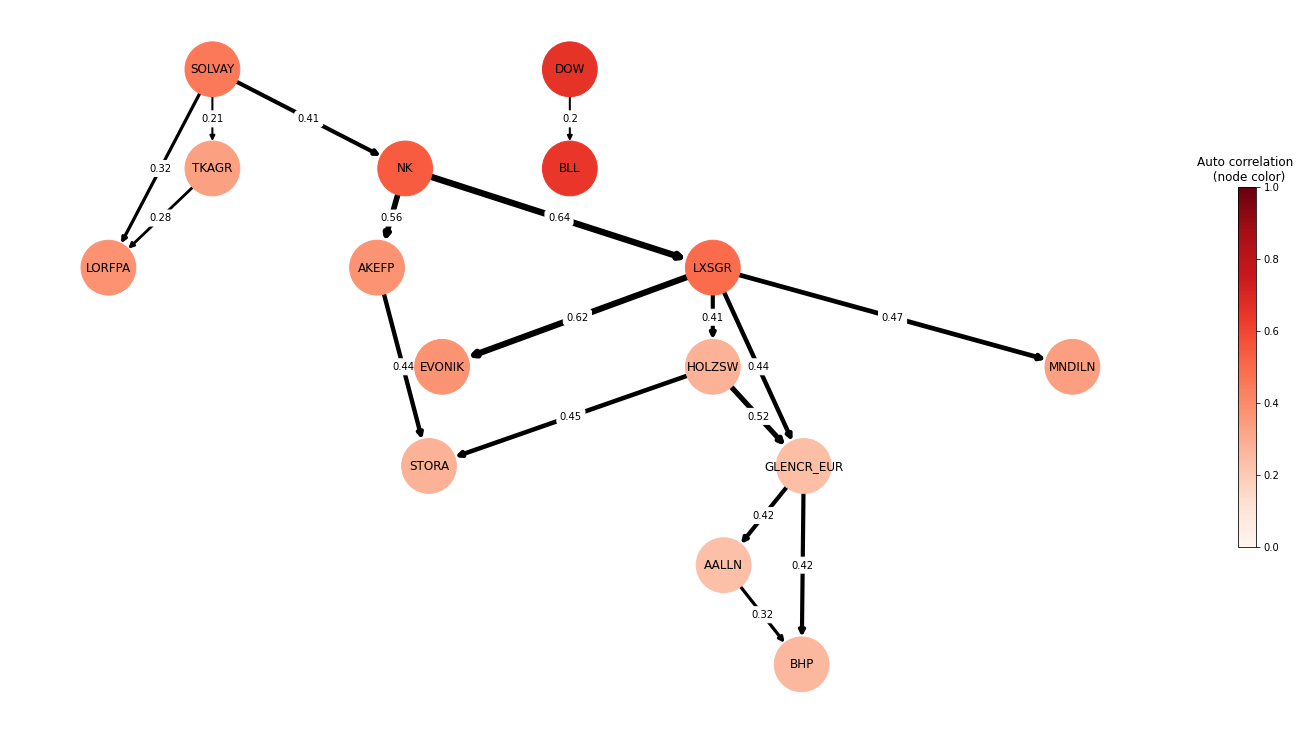

True


In [8]:
## Define and plot new graph with the structure discovered by the bayesian network algorithm and quantitative information
## determined by the conditional independence tests carried out via tigramite

## In addition, plot networks with link strength to determine edges' thickness and colors

plt.rcParams['figure.figsize'] = (18,10)

for status in ['0', '1', 'm1']:

    model_graph_final = nx.Graph()
    model_graph_final.add_nodes_from(list(model_graphs[status].nodes()))
    model_graph_final = model_graphs[status].to_directed()
    model_graph_final.add_weighted_edges_from(list(significant_arcs[status][['from', 'to', 'value']].to_records(index=False)))
    pos = graphviz_layout(model_graphs[status], prog="dot")
    
    weights = [model_graph_final[u][v]['weight'] for u,v in model_graph_final.edges()]

    nx.draw(model_graph_final, pos, with_labels=True, node_size = 3000, width=4,
            edge_color=weights, edge_cmap=plt.cm.coolwarm, edge_vmin=-1, edge_vmax=1,
            node_color=node_colors[status], cmap=plt.cm.Reds, vmin=0, vmax=1)
#     if status != 'm1':
#         pos_label = 0.5
#     else:
#         pos_label = 0.3
    pos_label = 0.5
    nx.draw_networkx_edge_labels(model_graph_final, pos, edge_labels=dict_edge_labels[status], rotate=False,
                                label_pos=pos_label)

    edge_bar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=-1, vmax=1)),
                            fraction=0.05, shrink=0.5, orientation='vertical')
    edge_bar.ax.set_title('Cross correlation')

    node_bar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(0,1)),
                 fraction=0.05, shrink=0.5, orientation='vertical')
    node_bar.ax.set_title('Auto correlation')

    plt.savefig('../Output/6.1_DBN_Results/' + sector + '_' + status + '.png')
    plt.show()
    
    nx.draw(model_graph_final, pos, with_labels=True, node_size = 3000, width=[10*i for i in list(link_strengths[status].values())],
            node_color=node_colors[status], cmap=plt.cm.Reds, vmin=0, vmax=1)
    nx.draw_networkx_edge_labels(model_graph_final, pos,
                                 edge_labels={k: np.round(link_strengths[status][k], 2) for k in link_strengths[status]},
                                 rotate=False, label_pos=pos_label)
    
    node_bar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(0,1)),
                 fraction=0.05, shrink=0.5, orientation='vertical')
    node_bar.ax.set_title('Auto correlation \n (node color)')
    
    plt.savefig('../Output/6.1_DBN_Results/' + sector + '_' + status + '_link_strength.png')
    plt.show()
    
    print(nx.is_directed_acyclic_graph(model_graph_final))
    
    # Produce .csv file with info about edges
    info_corr = pd.DataFrame(dict_edge_labels[status].items()).\
        rename(columns={0: 'edge', 1: 'lag'})
    info_corr[['from', 'to']] = pd.DataFrame(info_corr['edge'].tolist(), index=info_corr.index)
    info_strength = pd.DataFrame(link_strengths[status].items()).\
        rename(columns={0: 'edge', 1: 'link_strength'})
    info_strength[['from', 'to']] = pd.DataFrame(info_strength['edge'].tolist(), index=info_strength.index)
    significant_arcs[status].merge(info_corr[['from', 'to', 'lag']]).\
        rename(columns={'value': 'cross_corr'}).\
        merge(info_strength[['from', 'to', 'link_strength']]).\
        assign(link_strength = lambda x: np.round(x['link_strength'], 3),
               cross_corr = lambda x: np.round(x['cross_corr'], 3)).\
        to_csv('../Output/6.1_DBN_Results/' + sector + '_' + status + '_info_edges.csv', sep=';', index=False)